# Learning Uncertainty Sets

In [1]:
import cvxpy as cp
import scipy as sc
import numpy as np
import numpy.random as npr
import torch
from sklearn import datasets
import pandas as pd
import lropt
import sys
sys.path.append('..')
from utils import plot_tradeoff,plot_iters
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import warnings
warnings.filterwarnings("ignore")
plt.rcParams.update({
    "text.usetex":True,
    
    "font.size":18,
    "font.family": "serif"
})
colors = ["tab:blue", "tab:green", "tab:orange", 
          "blue", "tab:purple", "tab:brown", "tab:pink", "tab:grey", "red"]

### Example 2: Larger newsvendor problem
We now consider a larger Newsvendor problem, with two sets of products. 
The robust problem is 
\begin{equation*}
	\begin{array}{ll}
		\text{minimize} & \tau + y\\
		\text{subject to} & k_1^Tx_1 - p_1^T\min\{x_1, u\} \le \tau \quad \forall u \in \mathcal{U}(\theta) \\
		& k_2^Tx_2 - p_2^T\min\{x_2, u\} \le y \quad \forall u \in \mathcal{U}(\theta) \\
		& x_1 \geq x_2 \geq 0.
	\end{array}
\end{equation*}

In [2]:
# Formulate constants
n = 15
N = 300
np.random.seed(399)
k = npr.uniform(2,5,n)
p = k + npr.uniform(0.5,2,n)
k1 = npr.uniform(1,3,n)
p1 = k1 + npr.uniform(0,2,n)
k_tch = torch.tensor(k, requires_grad = True)
# p_tch = torch.tensor(p, requires_grad = True)
k1_tch = torch.tensor(k1, requires_grad = True)
p1_tch = torch.tensor(p1, requires_grad = True)

def loss(t,y,x, x1, p_tch, alpha, data, mu = 100, l=1000, quantile = 0.95, target = 0.):
    sums =  torch.mean(torch.maximum(
        torch.maximum(k_tch@x -data@p_tch, k_tch@x - p_tch@x) - t-alpha, 
        torch.tensor(0.,requires_grad = True)))+ torch.mean(torch.maximum(
        torch.maximum(k1_tch@x1 -data@p1_tch, k1_tch@x1 - p1_tch@x) - y-alpha, 
        torch.tensor(0.,requires_grad = True)))
    sums = sums/(2*(1-quantile)) + alpha
    return t +y + l*(sums - target) + (mu/2)*(sums - target)**2, t+y, 0.5*torch.mean((torch.maximum(
        torch.maximum(k_tch@x -data@p_tch, k_tch@x - p_tch@x) - t, 
        torch.tensor(0.,requires_grad = True))>=0.001).float()) + 0.5*torch.mean((torch.maximum(
        torch.maximum(k1_tch@x1 -data@p1_tch, k1_tch@x1 - p1_tch@x) - y, 
        torch.tensor(0.,requires_grad = True))>=0.001).float()), sums.detach().numpy()

def gen_demand(n, N, seed=399):
    np.random.seed(seed)
    F = np.random.normal(size = (n,2))
    sig = 0.1*F@(F.T)
    mu = np.random.uniform(-0.2,2,n)
    norms = np.random.multivariate_normal(mu,sig, N)
    d_train = np.exp(norms)
    return d_train

# Generate data
data = gen_demand(n,N*2)

scenarios = {}
num_scenarios = 5
for scene in range(num_scenarios):
    np.random.seed(scene)
    scenarios[scene] = {}
    scenarios[scene][0] = p + np.random.normal(0,0.1,n)

In [3]:
# Formulate uncertainty set
u = lropt.UncertainParameter(n,
                        uncertainty_set=lropt.Ellipsoidal(p=2,
                                                    data=data, loss = loss))
# Formulate the Robust Problem
x_r = cp.Variable(n)
x_1 = cp.Variable(n)
t = cp.Variable()
y = cp.Variable()
p = cp.Parameter(n)
# p1 = cp.Parameter(n)
p.value = scenarios[0][0]
# p1.value = scenarios[0][1]
objective = cp.Minimize(t+y)

constraints = [cp.maximum(k@x_r - p@x_r, k@x_r - p@u) <= t]
constraints += [cp.maximum(k1@x_1 - p1@x_1, k1@x_1 - p1@u) <= y]

constraints += [x_r >= 0, x_r >= x_1]

prob = lropt.RobustProblem(objective, constraints)
target = -0.05
test_p = 0.5
s = 5
train, test = train_test_split(data, test_size=int(data.shape[0]*test_p), random_state=s)
init = sc.linalg.sqrtm(sc.linalg.inv(np.cov(train.T)))
init_bval = -init@np.mean(train, axis=0)
# Train A and b
result1 = prob.train(lr = 0.00001, step=800, momentum = 0.8, optimizer = "SGD", seed = s, init_A = init, init_b = init_bval, fixb = False, init_mu = 5, init_lam = 0, target_cvar = target, init_alpha = 0., mu_multiplier = 1.01, test_percentage = test_p, scenarios = scenarios, num_scenarios = num_scenarios, max_inner_iter = 5)
df1 = result1.df
A_fin = result1.A
b_fin = result1.b

result3 = prob.train(eps = True, lr = 0.00001, step=800, momentum = 0.8, optimizer = "SGD", seed = s, init_A = init, init_b = init_bval, init_mu = 5, init_lam = 0,  target_cvar = target, init_alpha =0.,mu_multiplier = 1.01,test_percentage = test_p,scenarios = scenarios, num_scenarios = num_scenarios)
df_r2 = result3.df

# Grid search epsilon
result4 = prob.grid(epslst = np.linspace(0.01, 3, 40), init_A = result3.A, init_b = result3.b, seed = s, init_alpha = 0.,test_percentage = test_p,scenarios = scenarios, num_scenarios = num_scenarios)
dfgrid = result4.df

result5 = prob.grid(epslst = np.linspace(0.01, 3, 40), init_A = A_fin, init_b = b_fin, seed = s, init_alpha = 0.,test_percentage = test_p,scenarios = scenarios, num_scenarios = num_scenarios)
dfgrid2 = result5.df

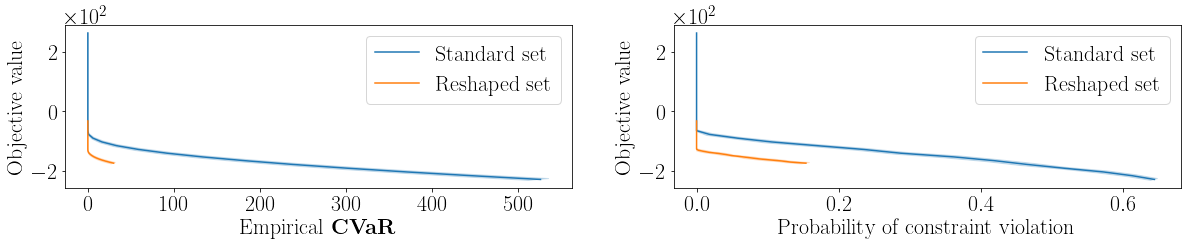

In [5]:
plot_tradeoff(dfgrid,dfgrid2,"News")

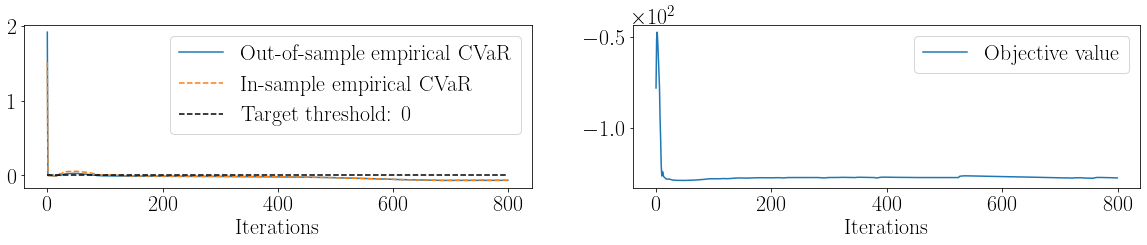

In [6]:
plot_iters(df1,"News", steps = 800)